# IDyOM

## Introduction and Recap

By now, you are likely familiar with what IDyOM is. As a recap:
- IDyOM is a statistical learning model that estimates the probability of each musical event
- It learns patterns from the current sequence to predict what comes next

The output from IDyOM is a measure known as Information Content. This is calculated as the negative log probability (base 2), which gives us a value measured in bits — the fundamental unit of information from the field of information theory (Shannon, 1948).

Information Content = -log₂(probability)

This measure is useful because it quantifies how surprising or unexpected an event is. One bit of information content means the event had a 50% probability (since -log₂(0.5) = 1). More generally, each additional bit doubles the number of equally likely alternatives that would need to be ruled out. For example, if we had 100 equally likely options, 1 bit would correspond to eliminating 50 of them, leaving 50 remaining possibilities.

As such, **higher information content** means the event was **less probable and more surprising**, while **lower information content** means the event was **more probable and less surprising**. An event with 0 bits of information content would have been completely certain (probability = 1.0), while an event with 3 bits would have had only a 12.5% chance of occurring (probability = 0.125).

It is clear then, that IDyOM is very relevant to understanding human perception of musical events. Information content allows us to simulate the amount of surprise we might feel at every note in a melody, or to summarise this surprise across a whole melody.

## Using IDyOM

We will first need to run a few commands to get IDyOM ready.

This first command simply brings IDyOM into our workspace so we can use it.

In [19]:
from melody_features import idyom_interface as idyom
print(f"IDyOM installed and ready to use: {idyom.is_idyom_installed()}")

IDyOM installed and ready to use: True


Now we need to tell IDyOM what melody we want to get the information content for. We supply this using the *path* to a MIDI file. This is just the filename, surrounded in quotation marks like `"davidwhyatt/Downloads/idyom_test.mid"` 

I have included a test file in this directory, its path is `/workspaces/Part-IB-Expectation-IDyOM/idyom_test.mid`


In [20]:
TEST_MIDI_DIR = "/workspaces/Part-IB-Expectation-IDyOM/input_files"
TEST_FILE = TEST_MIDI_DIR + "/idyom_test.mid"

Let's take a look at what the MIDI file contains. (enharmonic and beaming accuracy is left to be desired)

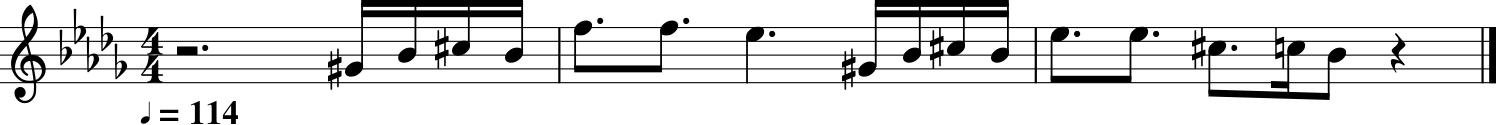

In [21]:
import music21
score = music21.converter.parse(TEST_FILE)
score.show()

from IPython.display import display, Audio
display(Audio("idyom_test.ogg"))

Great! So we have a single line melody with a range of different notes, and some repeated patterns. We might have some initial suspicions about what parts of the melody are more or less surprising, so let's test it out!

## Choosing viewpoints

In IDyOM, a viewpoint represents a certain aspect of musical structure. For example, the MIDI pitch number `cpitch` provides an absolute encoding of the pitch contents of the melody. Another approach is to use `cpint`, which instead corresponds to the interval between each successive pitch.

There are lots of different viewpoints to choose from when making predictions! But for what we seek to predict using these viewpoints, there are two main options: `cpitch` and `onset`. The goal of our model is to use whatever viewpoints we input to predict the value for each consecutive new note in the melody. **The output information content then corresponds to how likely the model thought that this next value was.**

Let's try a simple example!

In [22]:
# setting the model parameters
target_melody = TEST_MIDI_DIR
experiment_name = "testing_idyom"
target_viewpoints = ["cpitch"] # this is what we want to predict
source_viewpoints = [("cpitch", "cpint", "cpintfref")] # these are the viewpoints we will use for prediction
# strictly, this line corresponds to "a combination of pitches, intervals, and scale degrees" as our source viewpoint
ppm_order = None
detail = 3
models = ":stm"


In [23]:
idyom.run_idyom(input_path=target_melody,
                experiment_name=experiment_name,
                target_viewpoints=target_viewpoints,
                source_viewpoints=source_viewpoints,
                ppm_order=ppm_order,
                detail=detail,
                models=models)

** Putting Test dataset files in experiment history folder. **
** No pretraining dataset detected. **
** running lisp script **
To load "clsql":
  Load 1 ASDF system:
    clsql
; Loading "clsql"

To load "idyom":
  Load 1 ASDF system:
    idyom
; Loading "idyom"
................

Inserting 1 compositions into database: dataset 66010626185247.
| Progress: -----------------------------------------------|
** Finished! **


'/workspaces/Part-IB-Expectation-IDyOM/testing_idyom.dat'

This produced a `.dat` file with the output of the IDyOM model. Let's take a look at it.

In [24]:
import pandas as pd 

idyom_data = pd.read_csv("testing_idyom.dat", sep=r'\s+', header=0, na_values=["NA"])
idyom_data.head()

,dataset.id,melody.id,note.id,melody.name,vertint12,articulation,comma,voice,ornament,dyn,...,cpitch.68,cpitch.70,cpitch.72,cpitch.73,cpitch.75,cpitch.77,probability,ic,entropy,information.gain
0,66010626185247,1,1,idyom_test,NaN,0,0,1,0,80,...,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,2.584963,2.584963,NaN
1,66010626185247,1,2,idyom_test,NaN,0,0,1,0,80,...,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,2.584963,2.584963,0.000000
2,66010626185247,1,3,idyom_test,NaN,0,0,1,0,80,...,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,2.584963,2.584963,0.000000
3,66010626185247,1,4,idyom_test,NaN,0,0,1,0,80,...,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,0.166667,2.584963,2.584963,0.000000
4,66010626185247,1,5,idyom_test,NaN,0,0,1,0,80,...,0.111111,0.111111,0.111111,0.444444,0.111111,0.111111,0.111111,3.169925,2.281036,0.251629


There are quite a lot of columns here, but the ones we are interested in are `melody.id`, `note.id`, `melody.name`, `probability`, `ic`, `entropy` and `information.gain`. We'll extract just those columns.

In [25]:
idyom_cols = idyom_data[["melody.id", "note.id", "melody.name", 
                        "probability", "ic", "entropy", "information.gain"]]

Let's start simply by looking at the information content over the course of the melody.

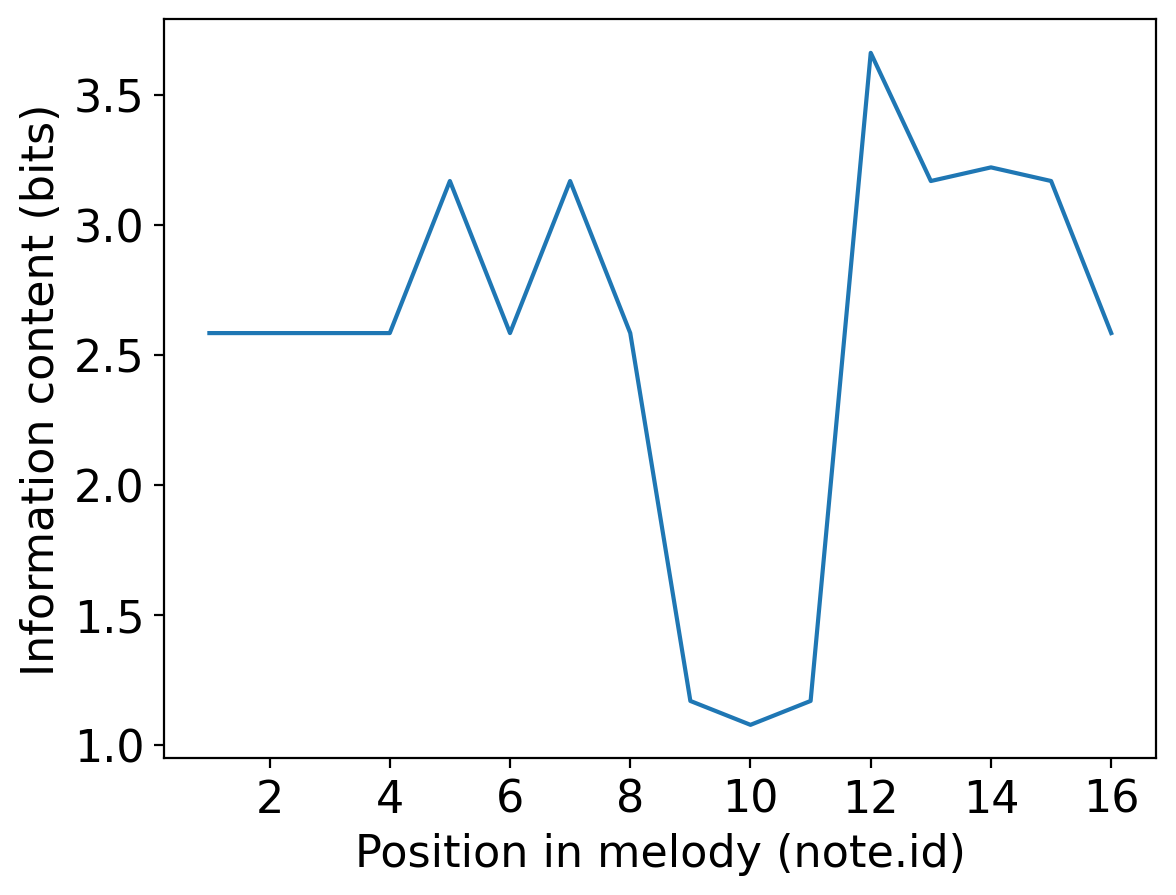

In [26]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

# setting which columns to plot
plt.plot(idyom_cols["note.id"], idyom_cols["ic"])

# setting axes labels and scaling x to integers
plt.xlabel("Position in melody (note.id)")
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))
plt.ylabel("Information content (bits)")
plt.show()

We see that information content is pretty stable as the first motif sounds, establishing the musical context. Then, when the pattern repeats itself, information content shoots downwards, as the model is not at all surprised by this repetition! 

Then, when the 12th note sounds, subverting the pattern we heard before with a note a tone lower, the information content hits a maximum point, showing how surprising this change was for the model!

Why not try modifying our code above, plotting instead `entropy` over time, or `probability`? 
How do the results differ?

## Application

Now that we've set the scene, it's your turn to run some of your own IDyOM analyses! You'll need a handful of MIDI files: you might want to create some yourself, using Sibelius/MuseScore/Logic/Ableton etc., or you can find some online. 

If you are stuck, you can find a good collection of well-used melodies here: 
- https://www.kaggle.com/datasets/sebastianeck/essen-folksong-database-conversion-and-tokenization/code 
or 
- https://www.kaggle.com/datasets/imsparsh/lakh-midi-clean

(I cannot guarantee the safety of the contents, use at your own risk and discretion)

Drag and drop your files into `input_files` and we are ready to go!



In [ ]:
# this will run with exactly the same settings as before 
# just using all the new files in `input_files`
idyom.run_idyom(input_path=target_melody,
                experiment_name=experiment_name,
                target_viewpoints=target_viewpoints,
                source_viewpoints=source_viewpoints,
                ppm_order=ppm_order,
                detail=detail,
                models=models)

Why not try out some other source viewpoints? Or try predicting `onset` instead? 

A full list of viewpoints can be found here: https://github.com/mtpearce/idyom/wiki/List-of-viewpoints 

In our example earlier, we used a linked viewpoint combining `cpitch`, `cpint`, and `cpintfref`.

How do the results differ if you just them one at a time?

(Hint: you only need to use brackets to link viewpoints together, they aren't needed if you're using one viewpoint at a time)